# Import

In [15]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from numpy import pi
import numpy as np
from gemseo import to_pickle
from gemseo import from_pickle
from gemseo import import_discipline
from lh2pac.utils import update_default_inputs
from numpy import array
from gemseo_oad_training.unit import convert_from



configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [3]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [4]:
update_default_inputs(disciplines, {"slst": 103361.02397518, "n_pax":120, "area":103.45450184, "ar":15.16956933})
disciplines[0].io.input_grammar.defaults


{'area': 103.45450184, 'ar': 15.16956933, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [5]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)


# Import surrogate model

In [7]:
surrogate_disciplines = from_pickle("my_surrogate_2.pkl")
surrogate_disciplines

Surrogate discipline: PolyReg_Sampling
   Dataset name: Sampling
   Dataset size: 20
   Surrogate model: PolynomialRegressor
   Inputs: aef, cef, sef
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# create sample dataset


In [8]:
surrogate_dataset = sample_disciplines([surrogate_disciplines], uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=5000)

 WARNING - 18:13:13: No coupling in MDA, switching chain_linearize to True.
    INFO - 18:13:13: *** Start Sampling execution ***
    INFO - 18:13:13: Sampling
    INFO - 18:13:13:    Disciplines: PolyReg_Sampling
    INFO - 18:13:13:    MDO formulation: MDF
    INFO - 18:13:13: Running the algorithm OT_MONTE_CARLO:
    INFO - 18:13:26:    100%|██████████| 5000/5000 [00:12<00:00, 389.93 it/sec]
    INFO - 18:13:26: *** End Sampling execution (time: 0:00:12.870152) ***


# Check stat

In [9]:
statistics = EmpiricalStatistics(surrogate_dataset)
mean = statistics.compute_mean()
print(mean)

std = statistics.compute_standard_deviation()
print(std)

{'aef': array([1.00658106]), 'cef': array([1.00665289]), 'fm': array([0.43748267]), 'length': array([32.]), 'mtom': array([63406.6715414]), 'sef': array([1.00684398]), 'span': array([39.61515162]), 'tofl': array([1954.04821055]), 'vapp': array([68.46889943]), 'vz': array([5.35039562])}
{'aef': array([0.00848757]), 'cef': array([0.00848433]), 'fm': array([0.01244047]), 'length': array([0.]), 'mtom': array([301.73366242]), 'sef': array([0.00850743]), 'span': array([0.]), 'tofl': array([17.68395401]), 'vapp': array([0.17814134]), 'vz': array([0.09686232])}


# Propagate uncertainties

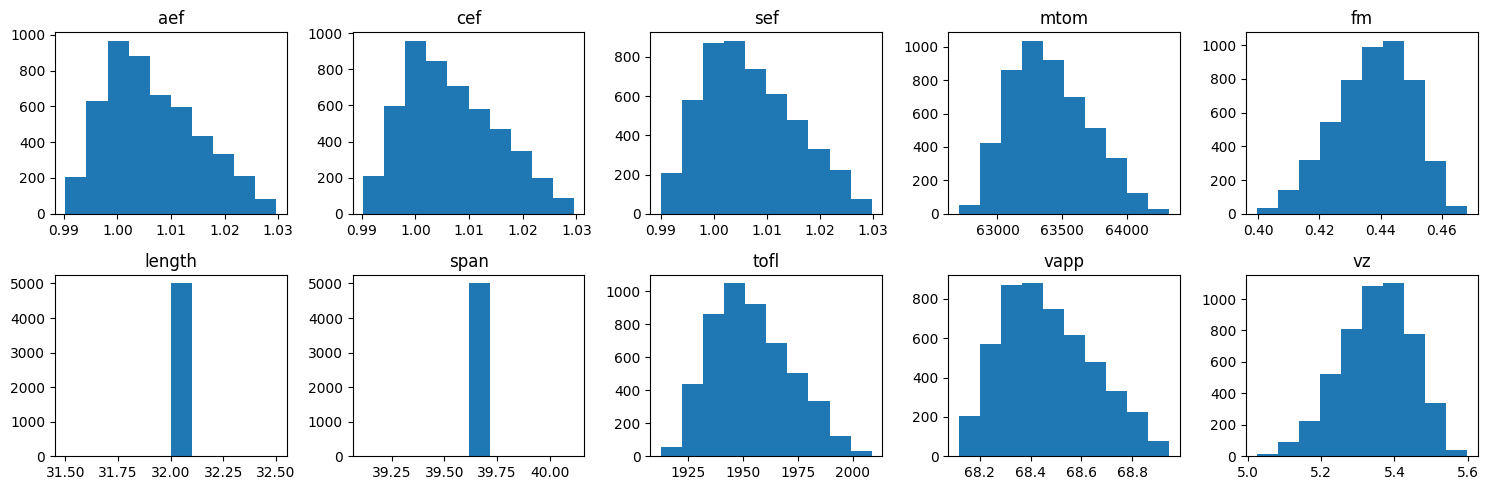

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

axes = axes.ravel()

for ax, name in zip(axes, ["aef", "cef", "sef", "mtom", "fm", "length", "span", "tofl", "vapp", "vz"]):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data)
    ax.set_title(name)

plt.tight_layout()
plt.show()

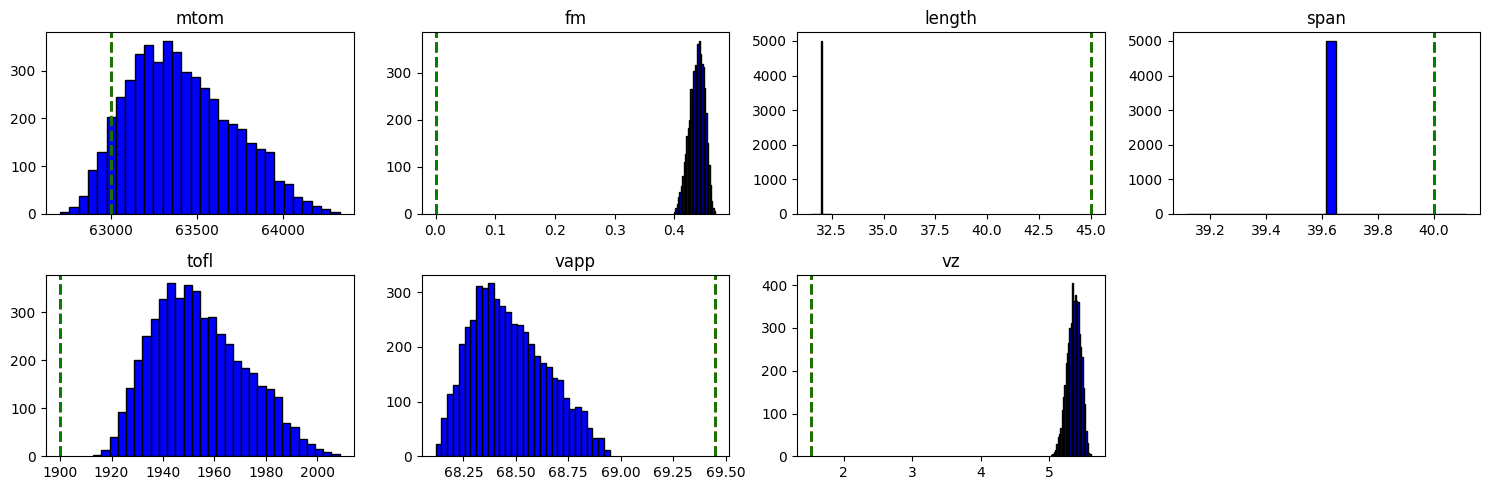

In [18]:
variable_names = ["mtom", "fm", "length", "span", "tofl", "vapp", "vz"]

constraints = [63000, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 
optimum_values = [63000, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.ravel()

for ax, name, cons_val, opt_val in zip(axes, variable_names, red_lines, optimum_values):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='blue', edgecolor='black')
    ax.axvline(cons_val, color='red', linestyle='--', linewidth=2)
    ax.axvline(opt_val, color='green', linestyle='--', linewidth=2)

    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


# Sobol analysis

In [25]:
sobol = SobolAnalysis()
samples = sobol.compute_samples([surrogate_disciplines], uncertain_space, 10000)
# to_pickle(samples, "samples.pkl")
sobol = SobolAnalysis(samples)
sobol.compute_indices(output_names=["mtom"])

 WARNING - 16:41:45: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:41:45: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 16:41:45: SobolAnalysisSamplingPhase
    INFO - 16:41:45:    Disciplines: PolyReg_Sampling
    INFO - 16:41:45:    MDO formulation: MDF
    INFO - 16:41:45: Running the algorithm OT_SOBOL_INDICES:
    INFO - 16:42:22:    100%|██████████| 10000/10000 [00:36<00:00, 270.76 it/sec]
    INFO - 16:42:22: *** End SobolAnalysisSamplingPhase execution (time: 0:00:37.068736) ***


SobolAnalysis.SensitivityIndices(first={'mtom': [{'aef': array([0.05625852]), 'cef': array([0.13667704]), 'sef': array([0.83554846])}]}, second={'mtom': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07741472]]), 'sef': array([[-0.06948837]])}, 'cef': {'aef': array([[-0.07741472]]), 'cef': array([[0.]]), 'sef': array([[-0.10615987]])}, 'sef': {'aef': array([[-0.06948837]]), 'cef': array([[-0.10615987]]), 'sef': array([[0.]])}}]}, total={'mtom': [{'aef': array([0.01708146]), 'cef': array([0.09087857]), 'sef': array([0.85285707])}]})

In [26]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'mtom': [{'aef': array([0.05625852]),
           'cef': array([0.13667704]),
           'sef': array([0.83554846])}]}
{'mtom': [{'aef': array([0.01708146]),
           'cef': array([0.09087857]),
           'sef': array([0.85285707])}]}


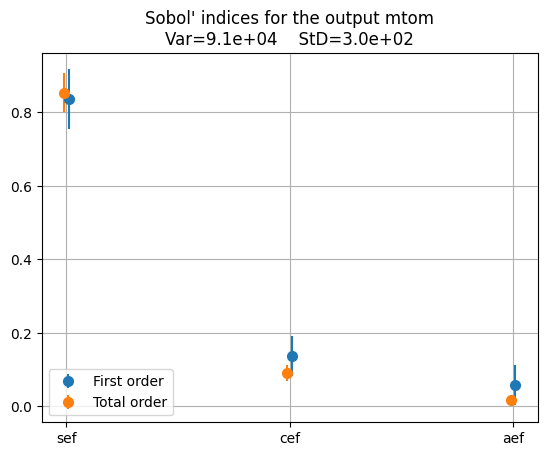

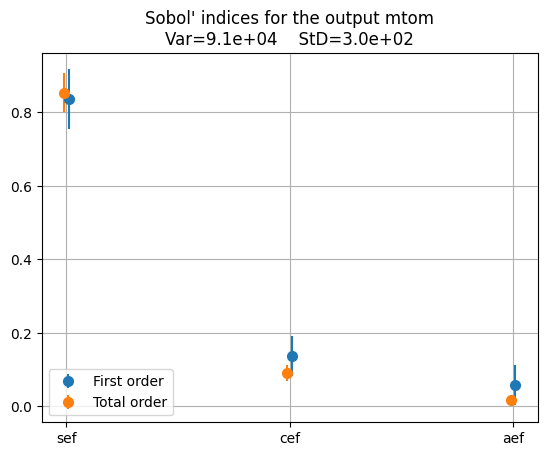

In [27]:
sobol.plot("mtom", save=False, show=False)